

<div align="center"> <b><h2>2η Εργαστήριακη Άσκηση</h2></b>
    
<div align="center">  Αριστοτέλης-Γεώργιος Συμπέθερος Α.Μ.:03116005

<div align="center">  Σάββας Σιφναίος Α.Μ.:03116080

<div align="center"> ΗΜΜΥ 

<div align="center"> ΕΜΠ

<div align="center"> Εξάμηνο:9o



In [3]:
#Worked in colab enviroment (for gpu accelerators)
from google.colab import drive
drive.mount('/content/drive')

## Imports 

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import librosa
from glob import glob
import os 
import re
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
import random
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from torch import optim
import torch 
import torchvision
import torch.nn as nn 
from torch.utils.data import Dataset,DataLoader
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.metrics import accuracy_score
from time import time 
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import SGD,Adam
from copy import deepcopy as copy
import hmm as hmm 
from pomegranate import *
import joblib
from time import time 

#Our files
from lib2 import *
from plot_confusion_matrix import * 
import lstm as neural
import parser as p


# PreLab

## Functions


In [ ]:
def mfsc_vs_mfcc(wavs,window,step,n1_2_idx,n2_2_idx,ns,Fs,frames,speakers):
    for i in [0,1]:
        mfsc=True
        title=["MFSC","MFCC"]
        for j in [0,1]:
            #MFSC Calculation
            if mfsc:
                mfscs_n1_1 = librosa.power_to_db(librosa.feature.melspectrogram(wavs[n1_2_idx[0]], Fs, n_fft=window, hop_length=step)).T[:, :13]
                mfscs_n1_2 = librosa.power_to_db(librosa.feature.melspectrogram(wavs[n1_2_idx[1]], Fs, n_fft=window, hop_length=step)).T[:, :13]
                
                mfscs_n2_1 = librosa.power_to_db(librosa.feature.melspectrogram(wavs[n2_2_idx[0]], Fs, n_fft=window, hop_length=step)).T[:, :13]
                mfscs_n2_2 = librosa.power_to_db(librosa.feature.melspectrogram(wavs[n2_2_idx[1]], Fs, n_fft=window, hop_length=step)).T[:, :13]

                n_2_idx=[n1_2_idx,n2_2_idx]

                n_corr_1=[np.corrcoef(mfscs_n1_1.T),np.corrcoef(mfscs_n2_1.T)]
                n_corr_2=[np.corrcoef(mfscs_n1_2.T),np.corrcoef(mfscs_n2_2.T)]
                mfsc=False
            #MFCC 
            else:
                mfccs_n1_1 = frames[n1_2_idx[0]]
                mfccs_n1_2 = frames[n1_2_idx[1]]
                
                mfccs_n2_1 = frames[n2_2_idx[0]]
                mfccs_n2_2 = frames[n2_2_idx[1]]
                
                n_corr_1=[np.corrcoef(mfccs_n1_1.T),np.corrcoef(mfccs_n2_1.T)]
                n_corr_2=[np.corrcoef(mfccs_n1_2.T),np.corrcoef(mfccs_n2_2.T)]

            #Plotting
            fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,8))

            fig.tight_layout(pad=5.0)
            im1=ax1.matshow(n_corr_1[i])
            ax1.set_title(f"{title[j]} of digit {ns[i]} from speaker {speakers[n_2_idx[i][0]]}")

            divider = make_axes_locatable(ax1)
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im1, cax=cax1)

            im2=ax2.matshow(n_corr_2[i])
            ax2.set_title(f"{title[j]} of digit {ns[i]} from speaker {speakers[n_2_idx[i][1]]}")

            divider = make_axes_locatable(ax2)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im2, cax=cax2)

In [ ]:
#Helper Function 
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    unique.sort(key = lambda x: x[1])
    ax.legend(*zip(*unique))

def scatter_plot(meanvec,stdvec,y):
    #Diffent arbitary choices of creating the final feuture vector, at this step we only care about the first 2 values
    #Mean values ,then Standard Deviation values
    feat_vec_1=[]
    for  i in range(0,len(meanvec)):
        feat_vec_1.append(np.concatenate((stdvec[i],meanvec[i]),axis=0))

    #Standard Deviation values,then Mean values  
    feat_vec_2=[]
    for  i in range(0,len(meanvec)):
        feat_vec_2.append(np.concatenate((meanvec[i],stdvec[i]),axis=0))
    
    #1 mean value 1 standard deviation value alternatively
    feat_vec_3=[]
    for  i in range(0,len(meanvec)):
        tmp=[]
        for j in range(0,len(meanvec[i])):
            tmp.append(meanvec[i][j])
            tmp.append(stdvec[i][j])
        feat_vec_3.append(np.asarray(tmp))    

    title=["Mean-STD","STD-Mean","Mean/STD Alternatively"]
    symbols=["o","v","^","<",">","s","p","h","+"]
    colors=["b","g","r","c","m","y","b","grey","orange"]
    for i,feat_vec in enumerate([feat_vec_1,feat_vec_2,feat_vec_3]):
        fig, ax = plt.subplots()
        ax.set_title(title[i])
        for i in range(0,len(feat_vec)):
            ax.scatter(feat_vec[i][0],feat_vec[i][1],marker=symbols[y[i]-1],color=colors[y[i]-1],label=y[i])
        ax.legend()
        legend_without_duplicate_labels(ax)
        plt.show()
        

In [ ]:
def scatter_plot_pca(meanvec,stdvec,y):
    #Feuture vector consisted of 39 mean values and 39 standard deviation values
    feat_vec=[]
    for  i in range(0,len(meanvec)):
        feat_vec.append(np.concatenate((meanvec[i],stdvec[i]),axis=0))

    #2 component PCA
    pca_2=PCA(n_components=2)
    feat_vec_pca_2=pca_2.fit_transform(np.asarray(feat_vec))
    print(f"PCA with 2 components gives {pca_2.explained_variance_ratio_.cumsum()[1]}% cumulative Variance")

    #3 component PCA
    pca_3=PCA(n_components=3)
    feat_vec_pca_3=pca_3.fit_transform(np.asarray(feat_vec))
    print(f"PCA with 3 components gives {pca_3.explained_variance_ratio_.cumsum()[2]}% cumulative Variance")

    #Check for 95% Cumulative Variance 
    pca_95=PCA(.95)
    tmp=pca_95.fit_transform(np.asarray(feat_vec))
    print(f"For 95% variance we need {tmp.shape[1]} components")


    #Code from NN Course (Lab) (at Ntua)
    n = 15
    pca_plot =PCA(n_components=n)
    trainPCA = pca_plot.fit_transform(np.asarray(feat_vec))
    cum_evar = pca_plot.explained_variance_ratio_.cumsum()
    plt.figure(figsize=(8,5))
    plt.title("Cumulative Variance as number of components grows ")
    plt.xlabel("Principal Component number")
    plt.ylabel('Cumulative Variance')
    plt.plot(cum_evar, linewidth=2,color="orange")
    plt.grid()
    plt.show()

    symbols=["o","v","^","<",">","s","p","h","+"]
    colors=["b","g","r","c","m","y","b","grey","orange"]

    #Plot for 2 components
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title("PCA=2")
    for i in range(0,feat_vec_pca_2.shape[0]):
        ax.scatter(feat_vec_pca_2[i][0],feat_vec_pca_2[i][1],marker=symbols[y[i]-1],color=colors[y[i]-1],label=y[i])
    ax.legend()
    ax.grid()
    legend_without_duplicate_labels(ax)
    ax.set_xlabel('1st Component')
    ax.set_ylabel('2nd Component')
    plt.show()

    #Plot for 3 components
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(0,feat_vec_pca_3.shape[0]):
        ax.scatter(feat_vec_pca_3[i][0],feat_vec_pca_3[i][1], feat_vec_pca_3[i][2],marker=symbols[y[i]-1],color=colors[y[i]-1],label=y[i])
    ax.set_title("PCA=3")
    ax.legend()
    legend_without_duplicate_labels(ax)
    ax.set_xlabel('1st Component')
    ax.set_ylabel('2nd Component')
    ax.set_zlabel('3d Component')


In [ ]:
#Function to get 2 different speakers for each digit n1 and n2 
def get_2_diff(y,speakers,n1,n2):
    flag=True
    n1_2_idx=[]
    speak=[]
    for i in range(0,len(y)):
        if y[i]==n1:
            if flag:
                n1_2_idx.append(i)
                speak.append(speakers[i])
                flag=False
            else:
                if (speak[0]==speakers[i]):
                    continue
                else:
                    speak.append(speakers[i])
                    n1_2_idx.append(i)
                    break

    flag=True
    n2_2_idx=[]
    tmp=-1
    for i in range(0,len(y)):
        if speakers[i]!=speak[0] and speakers[i]!=speak[1]: 
            continue
        if y[i]==n2:
            if flag:
                n2_2_idx.append(i)
                tmp=speakers[i]
                flag=False
            else:
                if (tmp==speakers[i]):
                    continue
                else:
                    n2_2_idx.append(i)
                    break

    return n1_2_idx,n2_2_idx

## Step 2

In [ ]:
def pre_parser(directory):
    #Dictionary for transforming numbers from string to corresponding int value
    str_to_int_dict=dict([("one",1),("two",2),("three",3),("four",4),("five",5),("six",6),("seven",7),("eight",8),("nine",9)])
    str_int_split = re.compile("([a-zA-Z]+)([0-9]+)") 
    
    # Parse relevant dataset info    
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [str_int_split.match(f.split('/')[8].split('.')[0]).groups() for f in files]
    y = [int(str_to_int_dict[f[0]]) for f in fnames]
    speakers = [f[1] for f in fnames]
    
    _, Fs = librosa.core.load(files[0], sr=None)
    def read_wav(f):
        wav, fs = librosa.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    return wavs,speakers,y,Fs

In [ ]:
wavs,speakers,y,Fs=pre_parser('/content/drive/MyDrive/Colab Notebooks/Pat_rec_collab_data/2nd_pat_rec_temp/digits/')

## Step3

In [ ]:
def mfcc_d_dd(wavs):
    # # Extract MFCCs for all wavs
    window = 25 * Fs // 1000
    step = 10 * Fs // 1000
    frames=[]
    d=[]
    dd=[]
    
    for i,wav in enumerate(wavs):
        tmp=librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=step, n_mfcc=13).T
        frames.append(tmp)
        d.append(librosa.feature.delta(tmp))
        dd.append(librosa.feature.delta(tmp,order=2))

    return frames,d,dd

In [ ]:
frames,d,dd=mfcc_d_dd(wavs)

## Step 4

In [ ]:
#Step 4
def plot_hist(n1,n2,y,frames,Fs):
    #Find all the instances of each digit
    n1_idx=[]
    n2_idx=[]
    for i in range(0,len(y)):
        if y[i]==n1:
            n1_idx.append(i)
        elif y[i]==n2:
            n2_idx.append(i)

    #For n1=8
    #From all of its instances get all of MFCCs first and second value and store them
    n1_mfcc_1=[]
    n1_mfcc_2=[]
    for i in n1_idx:
        for tmp in frames[i]:
            n1_mfcc_1.append(tmp[0])
            n1_mfcc_2.append(tmp[1])

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))

    #Histogram calculation and plotting 
    hist, bins = np.histogram(n1_mfcc_1, bins=25)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.set_title(f"Histogram of digit {n1} first MFCC coefficient")
    ax1.bar(center, hist, align='center', width=width)

    #Histogram calculation and plotting 
    hist, bins = np.histogram(n1_mfcc_2, bins=25)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax2.set_title(f"Histogram of digit {n1} second MFCC coefficient")
    ax2.bar(center, hist, align='center', width=width)


    #For n2=5
    #From all of its instances get all of MFCCs first and second value and store them
    n2_mfcc_1=[]
    n2_mfcc_2=[]
    for i in n2_idx:
        for tmp in frames[i]:
            n2_mfcc_1.append(tmp[0])
            n2_mfcc_2.append(tmp[1])

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
    
    #Histogram calculation and plotting 
    hist, bins = np.histogram(n2_mfcc_1, bins=25)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.set_title(f"Histogram of digit {n2} first MFCC coefficient")
    ax1.bar(center, hist, align='center', width=width)
    
    #Histogram calculation and plotting 
    hist, bins = np.histogram(n2_mfcc_2, bins=25)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax2.set_title(f"Histogram of digit {n2} second MFCC coefficient")
    ax2.bar(center, hist, align='center', width=width)



    window = 25 * Fs // 1000
    step = 10 * Fs // 1000
    
    #Get 2 different digits from 2 diferent speakers
    n1_2_idx,n2_2_idx=get_2_diff(y,speakers,n1,n2)
    n2_2_idx=[n2_2_idx[1],n2_2_idx[0]]
    
    mfsc_vs_mfcc(wavs,window,step,n1_2_idx,n2_2_idx,(n1,n2),Fs,frames,speakers)


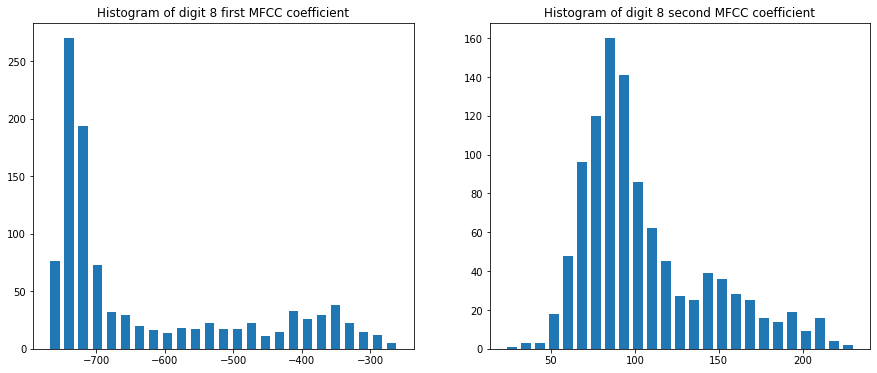

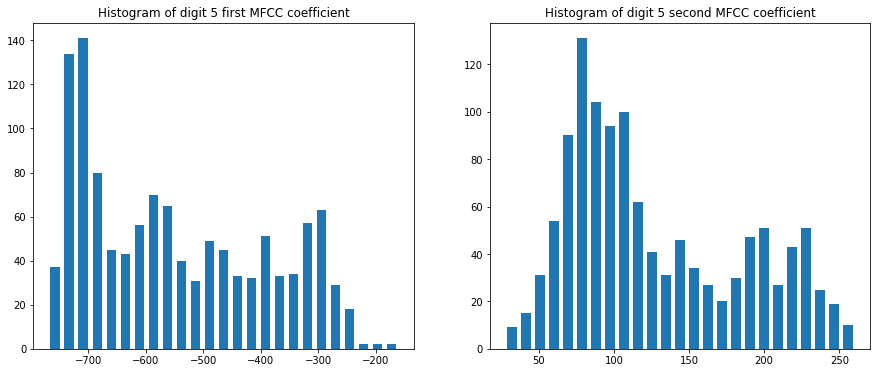

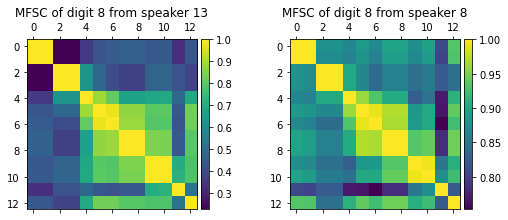

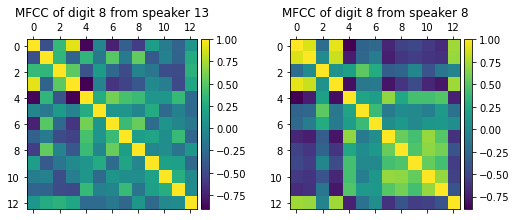

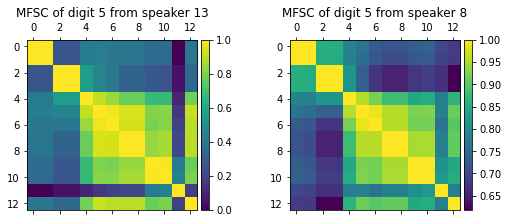

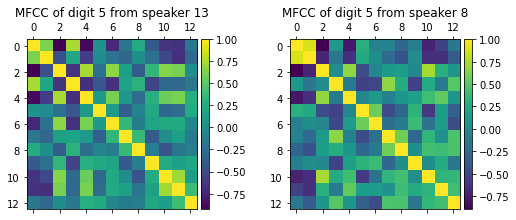

In [ ]:
#n1=8 and n2=5  (A.M.:03116080 & 03116005)
n1=8
n2=5

plot_hist(n1,n2,y,frames,Fs)

## Step 5-6

In [ ]:
#Step 5
def sctr_plots(frames,d,dd,y,pca_bool=False):
    vect=[]
    for i in range(0,len(y)):
        vect.append(np.concatenate((frames[i],d[i],dd[i]),axis=1))
    # #Step 5
    print(vect[0].shape)
    mean_vect=[]
    std_dev_vect=[]
    for i in range(0,len(y)):
        mean_vect.append(np.mean(vect[i],axis=0))
        std_dev_vect.append(np.std(vect[i],axis=0))

    if not pca_bool:
        #Scatter plot  
        scatter_plot(mean_vect,std_dev_vect,y)
    else:
        #We will keep the meac_vect-std_dev feuture vector
        scatter_plot_pca(mean_vect,std_dev_vect,y)

    feat_vec=[]
    for  i in range(0,len(mean_vect)):
        feat_vec.append(np.concatenate((mean_vect[i],std_dev_vect[i]),axis=0))

    return feat_vec

(89, 39)


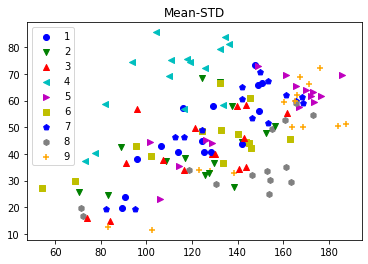

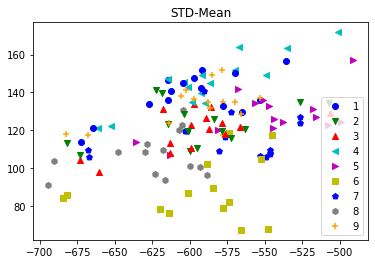

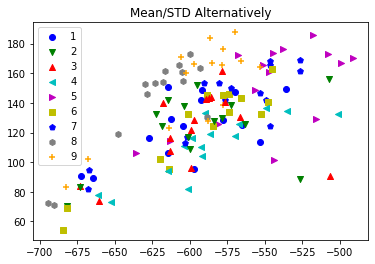

In [ ]:
#Scatter plot with 2 first dimensions 
feat_vec=sctr_plots(frames,d,dd,y)

(89, 39)
PCA with 2 components gives 0.7107913434835774% cumulative Variance
PCA with 3 components gives 0.8187258082767072% cumulative Variance
For 95% variance we need 8 components


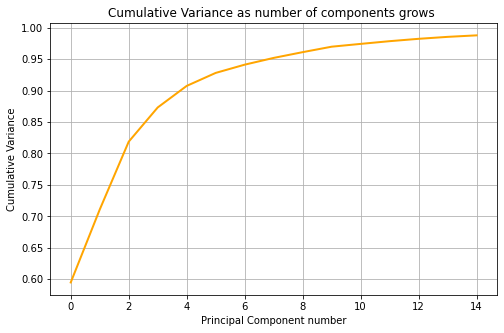

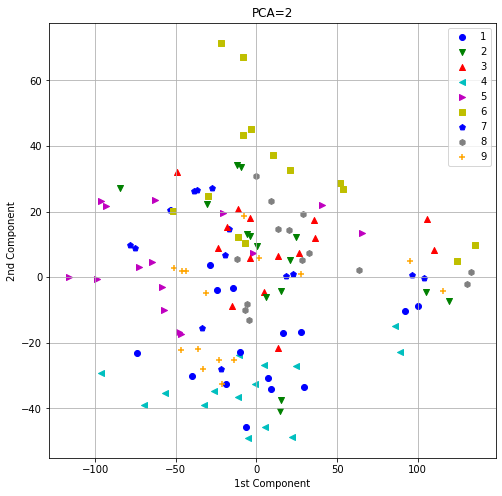

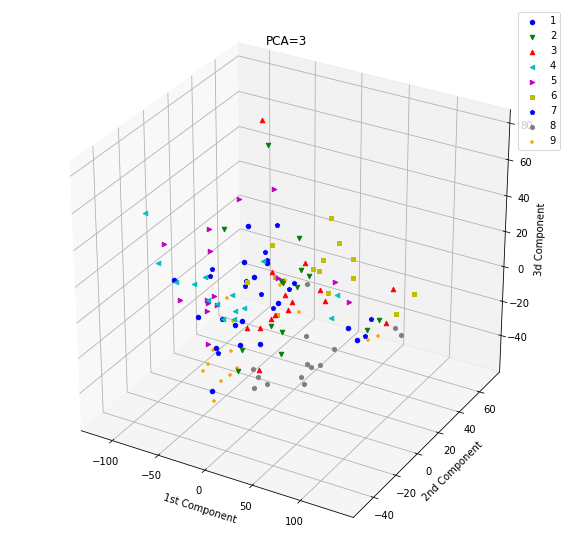

In [ ]:
#Scatter plots with PCA
feat_vec=sctr_plots(frames,d,dd,y,True)

## Step 7

In [ ]:
def split_data(fvect,y):
    #Could be done with train_test_split with stratisfy, but our implementation is kept
    bins=[[],[],[],[],[],[],[],[],[]]
    for i in range(0,len(y)):
        bins[y[i]-1].append(fvect[i])

    X_train=[]
    X_test=[]
    y_train=[]
    y_test=[]

    test=[]
    for i in range(0,len(bins)):
        indexes=list(range(0,len(bins[i])))

        train_indexes = random.sample(indexes,np.int(np.ceil(0.7*(len(bins[i])))))
        test_indexes=[i  for i in indexes if i not in train_indexes]

        X_train.append(([bins[i][j] for j in train_indexes]))
        y_train=np.concatenate((y_train,[i+1 for j in train_indexes]))
        X_test.append(([bins[i][j] for j in test_indexes]))
        y_test=np.concatenate((y_test,[i+1 for j in test_indexes]))
    
    X_train=[sample for samples_of_digit_list in X_train for sample  in samples_of_digit_list]
    X_test=[sample for samples_of_digit_list in X_test for sample  in samples_of_digit_list]

    return np.asarray(X_train),y_train.astype(int),np.asarray(X_test),y_test.astype(int)

In [ ]:
X_train,y_train,X_test,y_test=split_data(feat_vec,y)

In [ ]:
# Standardize data
scaler = StandardScaler()

scaler.fit(X_train)
X_train_std=scaler.transform(np.asarray(X_train))
X_test_std=scaler.transform(np.asarray(X_test))

In [ ]:
#Custom (Gaussian) Naive Bayes Classifier
time0 = time.time()
clf=CustomNBClassifier()
clf.fit(X_train_std,y_train-1)
print(f"Custom (Gaussian) Naive Bayes Classifier has accuracy: {clf.score(X_test_std,y_test-1)}")
print("\nTοtal Time (in minutes) =",(time.time()-time0)/60)

In [ ]:
#scikit learn (Gaussian) Naive Bayes Classifier
time0 = time.time()
gnb = GaussianNB()
gnb.fit(X_train_std,y_train)
print(f"Sklearn Gaussian Naive Bayes Classifier has accuracy: {accuracy_score(np.asarray(gnb.predict(X_test_std)),y_test)}")
print("\nTοtal Time (in minutes) =",(time.time()-time0)/60)


Sklearn Gaussian Naive Bayes Classifier has accuracy: 0.6388888888888888

Tοtal Time (in minutes) = 8.541345596313477e-05


In [ ]:
#KNN 3 neigbhors
time0 = time.time()
clf_3_KNN = KNeighborsClassifier(n_neighbors=3)
clf_3_KNN.fit(X_train_std,y_train)
print(f"KNN (k=3) Classifier has accuracy: {clf_3_KNN.score(X_test_std,y_test)}")
print("\nTοtal Time (in minutes) =",(time.time()-time0)/60)


KNN (k=3) Classifier has accuracy: 0.5555555555555556

Tοtal Time (in minutes) = 0.00017102162043253582


In [ ]:
#Linear SVC
time0 = time.time()
clf_LSVM = SVC(kernel='linear')
clf_LSVM.fit(X_train_std,y_train)
print(f"Linear SVM Classifier has accuracy: {clf_LSVM.score(X_test_std,y_test)}")
print("\nTοtal Time (in minutes) =",(time.time()-time0)/60)


In [ ]:
#MLP
time0 = time.time()
clf_mlp = MLPClassifier(hidden_layer_sizes=(20,20),max_iter=1000)
clf_mlp.fit(X_train_std,y_train)
print(f"MLP Classifier has accuracy: {clf_mlp.score(X_test_std,y_test)}")
print("\nTοtal Time (in minutes) =",(time.time()-time0)/60)


## Step 8 RNN-LSTM-GRU

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
#Create Dataset 
class RNNData(Dataset):
    def __init__(self, X, sequenceLength):
        'Initialization'
        self.X = X
        self.sequenceLength = sequenceLength    
    
    def __len__(self):
        'Denotes the total number of samples'
        return int(torch.floor(torch.tensor(len(self.X)/self.sequenceLength)))
    
    def __getitem__(self, index):
        sequence = self.X[index:index+self.sequenceLength]
        y = self.X[index+self.sequenceLength+1]
        return sequence, y

In [ ]:
def sinData (f, N, points, P):
    """
    Returns N input-output pairs of points-length sines and cosines of frequency
    f. The signals span P multiples of their periods.
    """
    #Compute oscillation periods.
    T = 1 / f
    phase_shift=set()
    #Generate N random starting points.
    while len(phase_shift) < N:
        phase_shift.add(np.random.rand()*2*np.pi)
    t = np.linspace(0,T,points)
    print(len(phase_shift))
    #Compute sines and cosines in all intervals.
    s_data = np.array ([])
    c_data = np.array ([])
    for i in range (N):
        ps= phase_shift.pop()
        s_slice = np.sin (2 * np.pi * f * t+ps)
        c_slice = np.cos (2 * np.pi * f * t+ps)
        if i == 0:
            s_data = s_slice
            c_data = c_slice
        else:
            s_data = np.vstack ((s_data, s_slice))
            c_data = np.vstack ((c_data, c_slice))
    return s_data, c_data

In [ ]:
class DigitsDataset (Dataset):
    def __init__ (self, array,num_of_features):
        self.initial = array
        self.feat = num_of_features
        #FloatTensor is needed by the nn.Linear module.
        self.data = torch.from_numpy (self.initial).type ('torch.FloatTensor')

    def __len__ (self):
        return self.initial.shape[0]

    def __getitem__ (self, idx):
        return self.data[idx, :self.feat], self.data[idx, self.feat:]

In [ ]:
X,y=sinData(40,500,10,1)
print(X[2,:].shape)
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.3)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.08)

500
(10,)


In [ ]:
from torch.utils.data import DataLoader
# Create Dataloader 
Xy_train = np.hstack ((X_train, y_train))
Xy_valid = np.hstack((X_val,y_val))
Xy_test = np.hstack ((X_test, y_test))
train_tensor = DigitsDataset (Xy_train,num_of_features=X[0,:].shape[0])
valid_tensor = DigitsDataset (Xy_valid,num_of_features=X[0,:].shape[0])
test_tensor = DigitsDataset (Xy_test,num_of_features=X[0,:].shape[0])

In [ ]:
train_loader = DataLoader (train_tensor, batch_size = 64, shuffle = True)
valid_loader = DataLoader (valid_tensor, batch_size = 32, shuffle = False)

In [ ]:
for X,y in train_loader :
    print((X.shape))
    break

torch.Size([64, 10])


In [ ]:
class myRNN (torch.nn.Module) :
    def __init__(self,inputs_size = 20, hidden_layer_size = 3, num_layers = 2,output_size =20,DEVICE = torch.device('cpu')):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = torch.nn.RNN(input_size=inputs_size,hidden_size=hidden_layer_size,num_layers=num_layers ,batch_first=True)
        self.num_layers = num_layers
        self.linear =torch.nn.Linear(hidden_layer_size,output_size)
        self.device = DEVICE
        self.input_size = inputs_size
    def forward (self,input):
        self.hidden_cell = torch.zeros(self.num_layers,len(input),self.hidden_layer_size).to(self.device)

        # Input must be 3D tensor 
        useful_input = input.view(-1,1,self.input_size).to(self.device)

        # Iterate over Train data (batch size is equal to all data)
        rnn_output ,self.hidden_cell = self.rnn(useful_input,self.hidden_cell)
        pred= self.linear(rnn_output)
        return pred

In [ ]:
class myLSTM(nn.Module):
    def __init__(self,input_size=20, output_size=20 ,num_layers=1,hidden_size=3,device=torch.device('cpu')):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.feature_size = hidden_size
        #First Linear Layer
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,output_size) 
        self.input_size = input_size
        self.device = device
    def forward (self,input):

        # # Input must be 3D tensor 
        # self.hidden_cell = torch.zeros(2,1,samples_num,self.hidden_size)

        # Initial Hidden State h_0 
        h_0 = torch.zeros(self.num_layers,len(input),self.hidden_size).to(self.device)
        
        # Initial Cell State c_0 (same as h_0)
        c_0 = torch.zeros(self.num_layers,len(input),self.hidden_size).to(self.device)
        

        useful_input = input.view(-1,1,self.input_size).to(self.device)
        
        # Iterate over Train data 
        lstm_output ,(h_n,c_n) = self.lstm(useful_input.to(self.device),(h_0,c_0))
        pred=self.linear(lstm_output)
        return pred

In [ ]:
class myGRU (torch.nn.Module) :
    def __init__(self,inputs_size = 20, hidden_layer_size = 3,num_layers =2, output_size =20,device=torch.device('cpu')):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = torch.nn.GRU(input_size= inputs_size,hidden_size= hidden_layer_size,num_layers= num_layers,batch_first=True)
        self.linear =torch.nn.Linear(in_features= hidden_layer_size,out_features=output_size)
        self.device = device
        self.num_layers = num_layers
        self.input_size = inputs_size
    def forward (self,input):
        pred = torch.zeros (len(input), 1, self.input_size).to(self.device)
        # Input must be 3D tensor 
        h_0 = torch.zeros(self.num_layers,len(input),self.hidden_layer_size).to(self.device)
        # Iterate over Train data 
        useful_input = input.view(-1,1,self.input_size).to(self.device)
        # Iterate over Train data 
        rnn_output ,h_n = self.rnn(useful_input.to(self.device),h_0)
        pred= self.linear(rnn_output)
        return pred

In [ ]:
from time import time
from torch.optim import Adam 
from copy import deepcopy as copy
# Lets Train 
def fit(Neural_Net,epochs,learning_rate,t_loader,v_loader,device=torch.device('cpu')):
    print(device)
    epochs_no_improve = 0
    n_epochs_stop = 25
    min_val_loss = np.Inf
    best_model = copy(Neural_Net)
    start_time = time()
    Neural_Net.to(device)
    optimizer = Adam(Neural_Net.parameters(),lr=learning_rate)
    loss_fun = nn.MSELoss()
    for epoch in range(epochs):
        Neural_Net.train()
        for data_batch , label_batch in t_loader :

            output = Neural_Net.forward(data_batch)
            loss = loss_fun(output.to(device),label_batch.view(-1,1,data_batch.shape[-1]).to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Neural_Net.hidden_cell.detach_ ()

        Neural_Net.eval()
        with torch.no_grad():
            valid_loss = 0
            for data_batch,label_batch in v_loader:
                valid_loss+= loss_fun(Neural_Net.forward(data_batch.to(device)),label_batch.view(-1,1,data_batch.shape[-1]).to(device)).item()
            if epoch%5==0 or epoch==epochs:
                print('The epoch is', epoch, 'and the validation loss is : ',valid_loss/len(v_loader))
            if valid_loss/len(v_loader) < min_val_loss :
                epochs_no_improve = 0
                min_val_loss = valid_loss/len(v_loader)
                best_model = copy(Neural_Net)
            else:
                epochs_no_improve+=1

            if epoch > 4 and epochs_no_improve==n_epochs_stop:
                print(f'Early Stopping at {epoch} epochs with validation loss :{valid_loss/len(v_loader)}!')
                Neural_Net = best_model 
                break
    print('Fit of Model Finished in ', time()-start_time,'seconds')
    return Neural_Net

In [ ]:
net = myRNN(inputs_size=10,output_size=10, num_layers=8,hidden_layer_size=10,DEVICE=DEVICE)
net = fit(net,200,0.01,train_loader,valid_loader,device = DEVICE)

cuda:0
The epoch is 0 and the validation loss is :  0.49552568793296814
The epoch is 5 and the validation loss is :  0.05828502029180527
The epoch is 10 and the validation loss is :  0.009002255275845528
The epoch is 15 and the validation loss is :  0.0011724669020622969
The epoch is 20 and the validation loss is :  0.0006863459711894393
The epoch is 25 and the validation loss is :  0.000435674941400066
The epoch is 30 and the validation loss is :  0.0002729355182964355
The epoch is 35 and the validation loss is :  0.00024173549900297076
The epoch is 40 and the validation loss is :  0.0002638782898429781
The epoch is 45 and the validation loss is :  0.00016228565073106438
The epoch is 50 and the validation loss is :  0.00030469437479041517
The epoch is 55 and the validation loss is :  0.0002140044089173898
The epoch is 60 and the validation loss is :  0.0003022321907337755
The epoch is 65 and the validation loss is :  9.463049354963005e-05
The epoch is 70 and the validation loss is :  

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:235: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


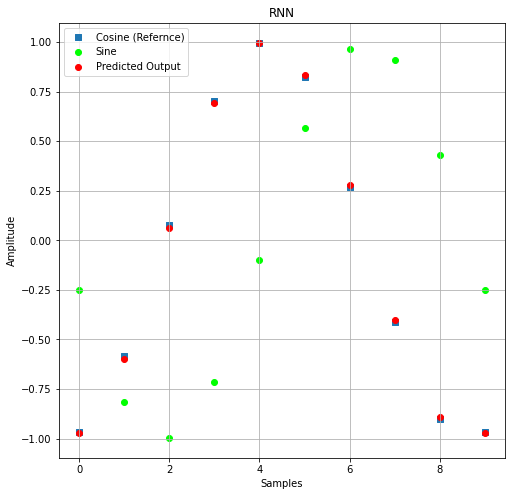

(RNN)Test set MSE loss is:9.830026829149574e-05


In [ ]:
ind = int(np.random.rand()*X_test.shape[0])
final_cosine=net.forward (torch.from_numpy (X_test[ind, :]).view(-1,1,X_test[0].shape[0]).float ())
t = np.arange (X_test[0].shape[0])
plt.figure(figsize=(8,8))
plt.scatter(t,y_test[ind,:],label='Cosine (Refernce)',marker='s')
plt.scatter(t,X_test[ind,:],label='Sine',color='lime')
plt.scatter (t, final_cosine.detach().cpu().numpy().reshape (X_test[0].shape[0],), label = 'Predicted Output',color='red')
plt.legend(loc='best')
plt.title("RNN")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

device=torch.device('cpu')
loss_fun = nn.MSELoss()
test_loader = DataLoader (test_tensor, batch_size = len(test_tensor), shuffle = False)
for test,test_true in test_loader:
    test_pred=net.forward(test).to(device)
    loss = loss_fun(test_pred,test_true.view(len(test_tensor),1,-1))
    print(f"(RNN)Test set MSE loss is:{loss}")



In [ ]:
net = myLSTM(input_size=10,output_size=10, num_layers=4,hidden_size=10,device=DEVICE)
net = fit(net,150,0.01,train_loader,valid_loader,device=DEVICE)

cuda:0
The epoch is 0 and the validation loss is :  0.5072690844535828
The epoch is 5 and the validation loss is :  0.30683258175849915
The epoch is 10 and the validation loss is :  0.24180369079113007
The epoch is 15 and the validation loss is :  0.20122945308685303
The epoch is 20 and the validation loss is :  0.02896246872842312
The epoch is 25 and the validation loss is :  0.003085329197347164
The epoch is 30 and the validation loss is :  0.001207148190587759
The epoch is 35 and the validation loss is :  0.0007000442128628492
The epoch is 40 and the validation loss is :  0.00040584185626357794
The epoch is 45 and the validation loss is :  0.0002962008002214134
The epoch is 50 and the validation loss is :  0.00025636982172727585
The epoch is 55 and the validation loss is :  0.00020154118828941137
The epoch is 60 and the validation loss is :  0.00013274705270305276
The epoch is 65 and the validation loss is :  0.00012090413656551391
The epoch is 70 and the validation loss is :  0.000

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


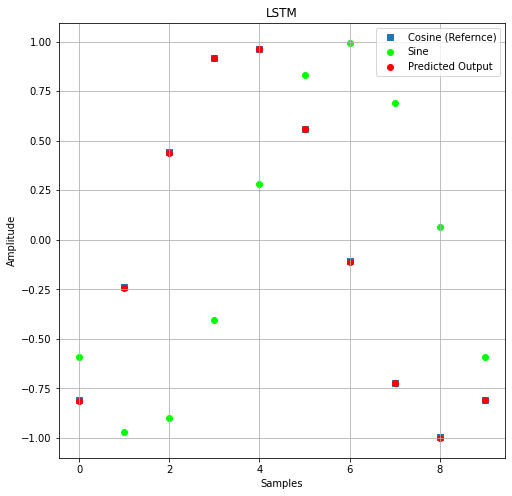

(LSTM) Test set MSE loss is:5.108024561195634e-05


In [ ]:
ind = int(np.random.rand()*X_test.shape[0])
final_cosine=net.forward (torch.from_numpy (X_test[ind, :]).view(-1,1,X_test[0].shape[0]).float ())
t = np.arange (X_test[0].shape[0])
plt.figure(figsize=(8,8))
plt.scatter(t,y_test[ind,:],label='Cosine (Refernce)',marker='s')
plt.scatter(t,X_test[ind,:],label='Sine',color='lime')
plt.scatter (t, final_cosine.detach().cpu().numpy().reshape (X_test[0].shape[0],), label = 'Predicted Output',color='red')
plt.legend(loc='best')
plt.title("LSTM")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()
device=torch.device('cpu')
loss_fun = nn.MSELoss()
test_loader = DataLoader (test_tensor, batch_size = len(test_tensor), shuffle = False)
for test,test_true in test_loader:
    test_pred=net.forward(test).to(device)
    loss = loss_fun(test_pred,test_true.view(len(test_tensor),1,-1))
    print(f"(LSTM) Test set MSE loss is:{loss}")


In [ ]:
net = myGRU(inputs_size=10, output_size=10 , num_layers=5,hidden_layer_size=10,device=DEVICE)
net = fit(net,150,1e-2,train_loader,valid_loader,device=DEVICE)

cuda:0
The epoch is 0 and the validation loss is :  0.5010424256324768
The epoch is 5 and the validation loss is :  0.22003230452537537
The epoch is 10 and the validation loss is :  0.01098452415317297
The epoch is 15 and the validation loss is :  0.001146558322943747
The epoch is 20 and the validation loss is :  0.0004337293212302029
The epoch is 25 and the validation loss is :  0.0002772308944258839
The epoch is 30 and the validation loss is :  0.00020741506887134165
The epoch is 35 and the validation loss is :  0.000149655737914145
The epoch is 40 and the validation loss is :  0.00017522423877380788
The epoch is 45 and the validation loss is :  0.0006245762924663723
The epoch is 50 and the validation loss is :  0.000535038358066231
The epoch is 55 and the validation loss is :  0.0002287077804794535
The epoch is 60 and the validation loss is :  0.00013632120680995286
The epoch is 65 and the validation loss is :  8.84943874552846e-05
The epoch is 70 and the validation loss is :  5.680

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:740: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


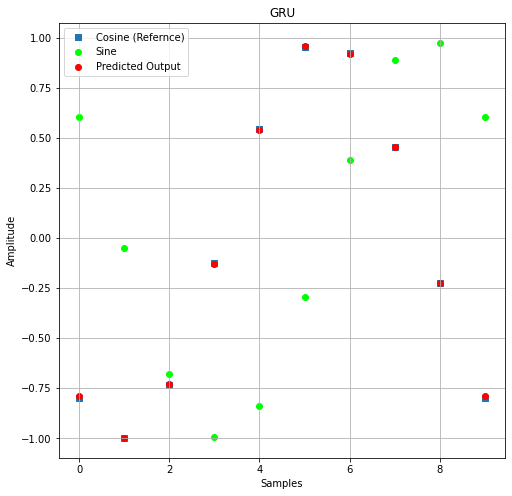

(GRU) Test set MSE loss is:2.5933202778105624e-05


In [ ]:
ind = int(np.random.rand()*X_test.shape[0])
final_cosine=net.forward (torch.from_numpy (X_test[ind, :]).view(-1,1,X_test[0].shape[0]).float ())
t = np.arange (X_test[0].shape[0])
plt.figure(figsize=(8,8))
plt.scatter(t,y_test[ind,:],label='Cosine (Refernce)',marker='s')
plt.scatter(t,X_test[ind,:],label='Sine',color='lime')
plt.scatter (t, final_cosine.detach().cpu().numpy().reshape (X_test[0].shape[0],), label = 'Predicted Output',color='red')
plt.legend(loc='best')
plt.title("GRU")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()
plt.show()

device=torch.device('cpu')
loss_fun = nn.MSELoss()
test_loader = DataLoader (test_tensor, batch_size = len(test_tensor), shuffle = False)
for test,test_true in test_loader:
    test_pred=net.forward(test).to(device)
    loss = loss_fun(test_pred,test_true.view(len(test_tensor),1,-1))
    print(f"(GRU) Test set MSE loss is:{loss}")


# LAB

## Step 9

In [ ]:
# Read Data
X_train_val, X_test, y_train_val, y_test, spk_train, spk_test=p.parser('/content/drive/MyDrive/Colab Notebooks/Pat_rec_collab_data/2nd_pat_rec_temp/recordings')

Total wavs: 3000


In [ ]:
# Split Data into Train, Validation and Test set 
X_train_val,X_test,y_train_val,y_test = joblib.load('Datasets.pkl')
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,stratify=y_train_val)

## Steps 10 - 11

In [ ]:
models = dict()
# Train a model for each possible combination of number_of_states = [1,2,3,4] and number_of_mixtures = [1,2,3,4,5]
for states in range (1,5):
    start_time = time ()
    for mixtures in range (1,6):
        models[(states,mixtures)] = []
        print('-'*60)
        for nums in range (10):
            model = hmm.HMM_GMM(n_states=states,n_mixtures=mixtures,max_iter=100)
            print(f'Fitting model for digit {nums} with n_states = {states} and n_mixtures = {mixtures}')
            models[(states,mixtures)].append (model.fit([X_train[i] for i,val in enumerate(y_train) if val==nums]))
        print(f'Total Time {time()-start_time} s' )

------------------------------------------------------------
Fitting model for digit 0 with n_states = 1 and n_mixtures = 1
Fitting model for digit 1 with n_states = 1 and n_mixtures = 1
Fitting model for digit 2 with n_states = 1 and n_mixtures = 1
Fitting model for digit 3 with n_states = 1 and n_mixtures = 1
Fitting model for digit 4 with n_states = 1 and n_mixtures = 1
Fitting model for digit 5 with n_states = 1 and n_mixtures = 1
Fitting model for digit 6 with n_states = 1 and n_mixtures = 1
Fitting model for digit 7 with n_states = 1 and n_mixtures = 1
Fitting model for digit 8 with n_states = 1 and n_mixtures = 1
Fitting model for digit 9 with n_states = 1 and n_mixtures = 1
Total Time 0.36745619773864746 s
------------------------------------------------------------
Fitting model for digit 0 with n_states = 1 and n_mixtures = 2
Fitting model for digit 1 with n_states = 1 and n_mixtures = 2
Fitting model for digit 2 with n_states = 1 and n_mixtures = 2
Fitting model for digit 3 

TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Total Time 92.24098181724548 s
------------------------------------------------------------
Fitting model for digit 0 with n_states = 2 and n_mixtures = 5
Fitting model for digit 1 with n_states = 2 and n_mixtures = 5
Fitting model for digit 2 with n_states = 2 and n_mixtures = 5
Fitting model for digit 3 with n_states = 2 and n_mixtures = 5
Fitting model for digit 4 with n_states = 2 and n_mixtures = 5
Fitting model for digit 5 with n_states = 2 and n_mixtures = 5
Fitting model for digit 6 with n_states = 2 and n_mixtures = 5
Fitting model for digit 7 with n_states = 2 and n_mixtures = 5
Fitting model for digit 8 with n_states = 2 and n_mixtures = 5
Fitting model for digit 9 with n_states = 2 and n_mixtures = 5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Total Time 133.46489930152893 s
------------------------------------------------------------
Fitting model for digit 0 with n_states = 3 and n_mixtures = 1
Fitting model for digit 1 with n_states = 3 and n_mixtures = 1
Fitting model for digit 2 with n_states = 3 and n_mixtures = 1
Fitting model for digit 3 with n_states = 3 and n_mixtures = 1
Fitting model for digit 4 with n_states = 3 and n_mixtures = 1
Fitting model for digit 5 with n_states = 3 and n_mixtures = 1
Fitting model for digit 6 with n_states = 3 and n_mixtures = 1
Fitting model for digit 7 with n_states = 3 and n_mixtures = 1
Fitting model for digit 8 with n_states = 3 and n_mixtures = 1
Fitting model for digit 9 with n_states = 3 and n_mixtures = 1
Total Time 11.69695258140564 s
------------------------------------------------------------
Fitting model for digit 0 with n_states = 3 and n_mixtures = 2
Fitting model for digit 1 with n_states = 3 and n_mixtures = 2
Fitting model for digit 2 with n_states = 3 and n_mixtures 

TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 8 with n_states = 3 and n_mixtures = 5
Fitting model for digit 9 with n_states = 3 and n_mixtures = 5
Total Time 192.28313493728638 s
------------------------------------------------------------
Fitting model for digit 0 with n_states = 4 and n_mixtures = 1
Fitting model for digit 1 with n_states = 4 and n_mixtures = 1
Fitting model for digit 2 with n_states = 4 and n_mixtures = 1
Fitting model for digit 3 with n_states = 4 and n_mixtures = 1
Fitting model for digit 4 with n_states = 4 and n_mixtures = 1
Fitting model for digit 5 with n_states = 4 and n_mixtures = 1
Fitting model for digit 6 with n_states = 4 and n_mixtures = 1
Fitting model for digit 7 with n_states = 4 and n_mixtures = 1
Fitting model for digit 8 with n_states = 4 and n_mixtures = 1
Fitting model for digit 9 with n_states = 4 and n_mixtures = 1
Total Time 16.734986782073975 s
------------------------------------------------------------
Fitting model for digit 0 with n_states = 4 and n_mixtures

TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 4 with n_states = 4 and n_mixtures = 4
Fitting model for digit 5 with n_states = 4 and n_mixtures = 4
Fitting model for digit 6 with n_states = 4 and n_mixtures = 4
Fitting model for digit 7 with n_states = 4 and n_mixtures = 4
Fitting model for digit 8 with n_states = 4 and n_mixtures = 4


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 9 with n_states = 4 and n_mixtures = 4
Total Time 153.39610648155212 s
------------------------------------------------------------
Fitting model for digit 0 with n_states = 4 and n_mixtures = 5
Fitting model for digit 1 with n_states = 4 and n_mixtures = 5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 2 with n_states = 4 and n_mixtures = 5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 3 with n_states = 4 and n_mixtures = 5
Fitting model for digit 4 with n_states = 4 and n_mixtures = 5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 5 with n_states = 4 and n_mixtures = 5
Fitting model for digit 6 with n_states = 4 and n_mixtures = 5
Fitting model for digit 7 with n_states = 4 and n_mixtures = 5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 8 with n_states = 4 and n_mixtures = 5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Fitting model for digit 9 with n_states = 4 and n_mixtures = 5
Total Time 208.35926461219788 s


## Step 12

In [ ]:
# Functions used for the prediction making process of a model.
def predict(models,X):
    logps = []
    preds = []
    for sample in X:
        logps = []
        for model in enumerate(models):
            logp,_= model[1].viterbi(sample)
            logps.append(logp)
        preds.append(np.argmax(logps))
    return np.asarray(preds)

# Function to calculate the accuracy score of a model
def score(model,X,y):
    predictions = predict(model,X)
    return np.equal(predictions,np.asarray(y)).sum()/len(y)

In [ ]:
# Calculate the accuracy score of each model trained above 
# Predictions of each model are saved in a dictionary indexed by the combination of parameters used in each model
# The accuracy score of each model is saved in a dictionary indexed by the combination of parameters used in each model
scores_val = dict()
preds= dict()
prints1 = ['hidden state','hidden states']
prints2 = ['Gaussian ','Gaussians']
for n_states in range(1,5):
    for n_mixtures in range(1,6):
        states = prints1[1]
        mixtures = prints2[1]
        if n_states == 1 :
            states = prints1[0]
        if n_mixtures == 1:
            mixtures =  prints2[0]
        preds[((n_states,n_mixtures))] = predict(models[(n_states,n_mixtures)],X_val)
        score_ = score(models[(n_states,n_mixtures)],X_val,y_val)
        scores_val[(n_states,n_mixtures)] = score_
        print(f'Accuracy of HMM-GMM with {n_states} {states} and {n_mixtures} {mixtures} :','{:.4f}'.format(score_))
    print('-'*65)

Accuracy of HMM-GMM with 1 hidden state and 1 Gaussian  : 0.8111
Accuracy of HMM-GMM with 1 hidden state and 2 Gaussians : 0.8648
Accuracy of HMM-GMM with 1 hidden state and 3 Gaussians : 0.9037
Accuracy of HMM-GMM with 1 hidden state and 4 Gaussians : 0.9111
Accuracy of HMM-GMM with 1 hidden state and 5 Gaussians : 0.9574
-----------------------------------------------------------------
Accuracy of HMM-GMM with 2 hidden states and 1 Gaussian  : 0.8519
Accuracy of HMM-GMM with 2 hidden states and 2 Gaussians : 0.9185
Accuracy of HMM-GMM with 2 hidden states and 3 Gaussians : 0.8963
Accuracy of HMM-GMM with 2 hidden states and 4 Gaussians : 0.9519
Accuracy of HMM-GMM with 2 hidden states and 5 Gaussians : 0.9704
-----------------------------------------------------------------
Accuracy of HMM-GMM with 3 hidden states and 1 Gaussian  : 0.8963
Accuracy of HMM-GMM with 3 hidden states and 2 Gaussians : 0.9259
Accuracy of HMM-GMM with 3 hidden states and 3 Gaussians : 0.9648
Accuracy of HMM

In [ ]:
# Find HMM-GMM with highest accuracy score
max_score = -1
for key in scores_val :
    if max_score < scores_val[key]:
        max_score = scores_val[key]
        indx = key
best_clf = models[indx]
print(f'The best combination of parametres is : {indx[0]} hidden state(s) , {indx[1]} Gaussian(s)')

The best combination of parametres is : 3 hidden state(s) , 4 Gaussian(s)


In [ ]:
print('The accuracy of the best classifier on the test set is : ', '{:.2f}'.format(score(best_clf,X_test,y_test)))

The accuracy of the best classifier on the test set is :  0.97


## Step 13

Confusion matrix, without normalization
Confusion matrix, without normalization


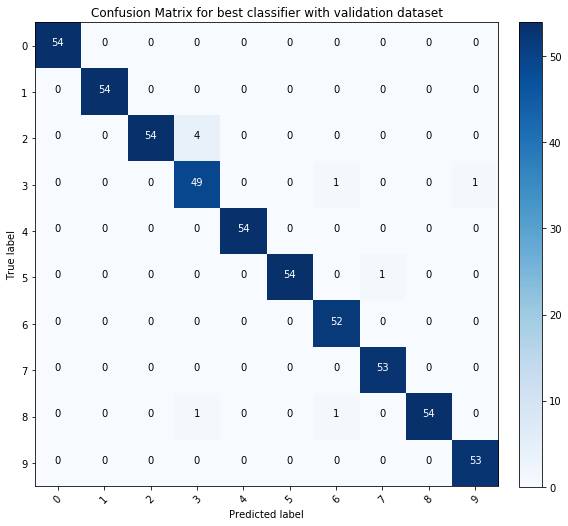

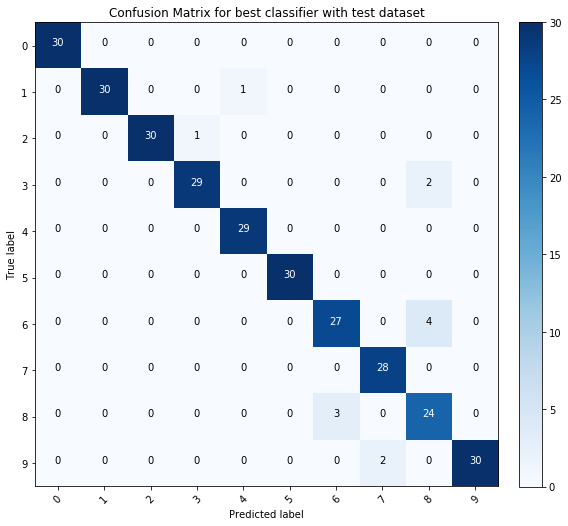

In [ ]:

cm_val = confusion_matrix(preds[(4,4)],y_val)
cm_test = confusion_matrix(predict(models[(4,4)],X_test),y_test)
plot_confusion_matrix(cm_val ,classes = list(map(lambda x:str(x),list(range(10)))), title = 'Confusion Matrix for best classifier with validation dataset')
plot_confusion_matrix(cm_test , classes = list(map(lambda x:str(x),list(range(10)))),title = 'Confusion Matrix for best classifier with test dataset')

## Step 14

In [ ]:
#  Creation of Datasets
X_test =X_test
y_test =y_test
xy_train=neural.FrameLevelDataset(X_train,y_train)
xy_val=neural.FrameLevelDataset(X_val,y_val)
xy_test=neural.FrameLevelDataset(X_test,y_test.tolist())

In [ ]:
# Initialization of dataloaders

train_batch_size=64
val_batch_size=32
train_loader = DataLoader (xy_train, batch_size = train_batch_size, shuffle = True)
valid_loader = DataLoader (xy_val, batch_size = val_batch_size, shuffle = False)
test_loader = DataLoader(xy_test , batch_size =2  , shuffle = False)

### 1)  
Η υλοποίηση του δικτύου πραγματοποιείται στο αρχείο lstm.py

### 2) 


In [ ]:
# Ιnitialization neural network 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = neural.BasicLSTM(input_dim=X_train[0].shape[-1], rnn_size= 20, output_dim=10, num_layers=1,DEVICE=DEVICE)

### 3) 

In [ ]:
def fit(model,epochs,lr,t_loader,v_loader,L2_normal = 0,val=False,earlyStopping=False,time_b=False,DEVICE=torch.device('cpu')):
        # Create model and convert to a cuda compatible oject
        model = model.double().to(DEVICE)

        val_losses = list()
        train_losses = list()
        # Parameters for the early stopping implementation
        n_epochs_stop = 6
        epochs_no_improve = 0
        min_val_loss = np.Inf

        # Initialization of loss function and optimizer 
        loss_fun = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(),lr=lr,weight_decay=L2_normal)
        best_model = copy(model)
   
        for epoch in range(epochs):
            ep_loss = 0 
            model.train()
            ttl_forw_time=0
            epoch_time=time()
            forward_times=[]
            backward_times=[]
            # Iterate over batches of the Train Dataset
            for X,labels,lengths in t_loader:
                time_1=time()
                out = model.forward(X.double(),lengths)
                time_2=time()
                forward_times.append(time_2-time_1)
                loss = loss_fun(out,labels.to(DEVICE))
                ep_loss += loss/len(t_loader)
                time_3=time()
                loss.backward()
                time_3_5=time()
                backward_times.append(time_3_5-time_3)
                optimizer.step()
                optimizer.zero_grad()
                time_4=time()
                ttl_forw_time+=time_2-time_1
                # print(f"Forward method time is:{time_2-time_1}")
                # print(f"Loss backward time is: {time_3_5-time_3}")
            train_losses.append(ep_loss)
            if time_b:
                # print(f"Epoch {epoch+1} mean of forward time is :{np.mean(forward_times[])}")
                # print(f"Epoch {epoch+1} mean of backward time is :{np.mean(backward_times)}")
                print(f"Epoch {epoch+1} time is:{time()-epoch_time}")                
                # print(f'Epoch {epoch+1} : Train loss is {ep_loss} and total time for forward passes {np.round(ttl_forw_time,4)}, total time of epoch: {time()-epoch_time}')
            else:
                print(f'Epoch {epoch+1} : Train loss is {ep_loss}')
            model.eval()
            if val :
                with torch.no_grad():
                    validation_loss = 0 
                    # Iterate over validation set in batches, to check to validation loss
                    for X,labels,lengths in v_loader :
                        out_val = model.forward(X.double(),lengths)
                        loss  = loss_fun(out_val.to(DEVICE),labels.to(DEVICE))
                        validation_loss+=loss/len(v_loader)
                    val_losses.append(validation_loss)
                    
                    print(f'Epoch {epoch+1} : Validation Loss is {validation_loss}')
                    
                    # Early stopping implementation
                    if earlyStopping:
                        rounded_loss = np.round(validation_loss.item(),decimals=3)
                        if rounded_loss < min_val_loss :
                            epochs_no_improve = 0
                            min_val_loss = rounded_loss
                            best_model = copy(model)
                        else:
                            epochs_no_improve+=1

                        if epoch > 13 and epochs_no_improve==n_epochs_stop:
                            print('Early Stopping!')
                            model = best_model 
                            break
                        
                    print('-'*50)
        if val:
            return model ,(list(map(lambda x:x.item(),train_losses)),list(map(lambda x:x.item(),val_losses)))
        else :
            return model,list(map(lambda x:x.item(),train_losses))

In [ ]:
model_trainned ,losses= fit(model,40,0.05,train_loader,valid_loader,DEVICE=DEVICE)

Epoch 1 : Train loss is 1.578521164355709
Epoch 2 : Train loss is 0.9721122484280591
Epoch 3 : Train loss is 0.7572213655930884
Epoch 4 : Train loss is 0.5825523177108725
Epoch 5 : Train loss is 0.4907612427025428
Epoch 6 : Train loss is 0.39549840846072515
Epoch 7 : Train loss is 0.3661516946563943
Epoch 8 : Train loss is 0.23438822917240695
Epoch 9 : Train loss is 0.20547967596351624
Epoch 10 : Train loss is 0.21820402291985078
Epoch 11 : Train loss is 0.24947459962967433
Epoch 12 : Train loss is 0.22448941455571006
Epoch 13 : Train loss is 0.1997708500904175
Epoch 14 : Train loss is 0.1778247881278443
Epoch 15 : Train loss is 0.25946613229726895
Epoch 16 : Train loss is 0.23764505904142644
Epoch 17 : Train loss is 0.16573229374538248
Epoch 18 : Train loss is 0.10841321163261498
Epoch 19 : Train loss is 0.15569658817042017
Epoch 20 : Train loss is 0.1221377502779278
Epoch 21 : Train loss is 0.11648203070024954
Epoch 22 : Train loss is 0.2530456294725508
Epoch 23 : Train loss is 0.224

### 4)

In [ ]:
model_trainned ,losses= fit(model,40,0.05,train_loader,valid_loader,val=True,DEVICE=DEVICE)

Epoch 1 : Train loss is 0.11945278250636909
Epoch 1 : Validation Loss is 0.3365616759439712
--------------------------------------------------
Epoch 2 : Train loss is 0.11874366492860865
Epoch 2 : Validation Loss is 0.2945280089381717
--------------------------------------------------
Epoch 3 : Train loss is 0.1138667808755761
Epoch 3 : Validation Loss is 0.2922964466580756
--------------------------------------------------
Epoch 4 : Train loss is 0.10817226516480719
Epoch 4 : Validation Loss is 0.26923056722085353
--------------------------------------------------
Epoch 5 : Train loss is 0.07267642496670408
Epoch 5 : Validation Loss is 0.24904435472020062
--------------------------------------------------
Epoch 6 : Train loss is 0.09607307178668457
Epoch 6 : Validation Loss is 0.39930552135661956
--------------------------------------------------
Epoch 7 : Train loss is 0.14661967588737415
Epoch 7 : Validation Loss is 0.23834890568321046
-----------------------------------------------

Προτού προχωρήσουμε στην αξιοποίηση επιπρόσθετων μεθόδων για την βελτίωση των επιδόσεων του μοντέλου μας, αποφασίσουμε να πραγματοποιήσουμε ένα αρκετά περιορισμένα GridSeach με σκοπό την εύρεση των συνδυασμών εκείνων των παραμέτρων rnn_size και num_layers που οδηγούν στα μοντέλα με τις 4 καλύτερες επιδόσεις ως προς την μετρική accuarcy. 

In [ ]:
# Create all models for all possible combinations of rnn_size = [20,40,60] and num_layers =[1,2,3]

# Dictionary to save the trainned model as well as the loss in train and validation set 
results = dict()
for size in [20,40,60]:
    print('='*60)
    for layers in [1,2,3]:
        print(f'rnn_size = {size} , num_layers = {layers}')
        print('='*60)
        model = neural.BasicLSTM(input_dim=X_train[0].shape[-1], rnn_size= size, output_dim=10, num_layers=layers,DEVICE=DEVICE)

        results[(size,layers)] = fit(model,40,0.003,train_loader,valid_loader,val=True,DEVICE=DEVICE)
        

rnn_size = 20 , num_layers = 1
Epoch 1 : Train loss is 2.209284604836223
Epoch 1 : Validation Loss is 2.0698162458038034
--------------------------------------------------
Epoch 2 : Train loss is 1.839759046442561
Epoch 2 : Validation Loss is 1.6644424357568204
--------------------------------------------------
Epoch 3 : Train loss is 1.4463058923982408
Epoch 3 : Validation Loss is 1.3151179426194926
--------------------------------------------------
Epoch 4 : Train loss is 1.135848712334274
Epoch 4 : Validation Loss is 1.0378478341044468
--------------------------------------------------
Epoch 5 : Train loss is 0.9036868980444763
Epoch 5 : Validation Loss is 0.8578789492832207
--------------------------------------------------
Epoch 6 : Train loss is 0.7813274551747389
Epoch 6 : Validation Loss is 0.7772721700304064
--------------------------------------------------
Epoch 7 : Train loss is 0.6732903233836269
Epoch 7 : Validation Loss is 0.7277290278315511
-----------------------------

In [ ]:
# Definition of a function that calculates the accuracy of a model 
def score(model,loader,DEVICE=torch.device('cpu')) :
    preds = []
    y_test = []
    for X,y,lengths in loader :
        X.to(DEVICE)
        with torch.no_grad():
            out = model(X,lengths)
        if X.size()[0] !=1 :
            for y_pred,label in zip(out,y) :
                tmp = torch.argmax(y_pred)
                preds.append(tmp.item())
                y_test.append(label)
        else :
            y_pred = torch.argmax(out).item()
            preds.append(y_pred)
            y_test.append(y)
    return accuracy_score(preds,y_test),preds

In [ ]:
# Iterate over the 9 models we trainned in previous cell, in order to find the n  (user definied) best models accoriding to the accuracy metric
keys =[]
tmp_dict = copy(results)
number_of_best_models = 4
best_accs = []
for i in range(number_of_best_models):
    best_acc = -1
    best_key=None   
    for key in tmp_dict:
        model = tmp_dict[key][0]
        accuracy,_ = score(model,valid_loader)
        if accuracy >= best_acc:
            best_acc = accuracy
            best_key=(key)
    best_accs.append(best_acc)
    keys.append(best_key)
    del tmp_dict[best_key] 
for i,(combo, accuracy) in enumerate(zip(keys,best_accs)):
    print(f'Number {i+1} best model(accuracy = {accuracy}) : rnn_size = {combo[0]} , num_layers = {combo[1]}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Number 1 best model(accuracy = 0.9888888888888889) : rnn_size = 60 , num_layers = 3
Number 2 best model(accuracy = 0.9833333333333333) : rnn_size = 60 , num_layers = 2
Number 3 best model(accuracy = 0.9833333333333333) : rnn_size = 40 , num_layers = 1
Number 4 best model(accuracy = 0.9814814814814815) : rnn_size = 60 , num_layers = 1


### 5)

In [ ]:
# We add dropout and l2 regularization to the best 4 models selected above 
# Again we create and train models for each possible combination of dropout = [0,0.1,0.2,0.3] and L2 regularization =[0,0.0001,0.0002]
# The trainned models and their losses in train and validation set are once again saved in dictionary indexed by the parameteres used in each model 

dropouts = [0,0.1,0.2,0.3]
L2_regs = [0,0.0001,0.0002]
new_results = dict()
for key in keys:
    for dropout in dropouts :
        model = neural.BasicLSTM(input_dim=X_train[0].shape[-1], rnn_size= key[0], output_dim=10, num_layers=key[1],dropout=dropout,DEVICE=DEVICE)
        
        for L2 in L2_regs:
            print('='*67)
            print(f'rnn_size = {key[0]} , num_layers = {key[1]}, dropout = {dropout}, L2_regularization = {L2}')
            print('='*67)
            new_results[(key[0],key[1],dropout,L2)] = fit(model,30,0.003,train_loader,valid_loader,L2_normal=L2,val=True,DEVICE=DEVICE)

rnn_size = 60 , num_layers = 3, dropout = 0, L2_regularization = 0
Epoch 1 : Train loss is 1.8781617809450528
Epoch 1 : Validation Loss is 1.299446222388275
--------------------------------------------------
Epoch 2 : Train loss is 0.9251600541132461
Epoch 2 : Validation Loss is 0.8120205907417823
--------------------------------------------------
Epoch 3 : Train loss is 0.5547540936331381
Epoch 3 : Validation Loss is 0.4789938361731434
--------------------------------------------------
Epoch 4 : Train loss is 0.3918657328458338
Epoch 4 : Validation Loss is 0.35456035764729193
--------------------------------------------------
Epoch 5 : Train loss is 0.3085467683621822
Epoch 5 : Validation Loss is 0.5243195283616211
--------------------------------------------------
Epoch 6 : Train loss is 0.35612069208841124
Epoch 6 : Validation Loss is 0.41813042064810463
--------------------------------------------------
Epoch 7 : Train loss is 0.2552505236909184
Epoch 7 : Validation Loss is 0.24895

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 : Train loss is 2.1528365071213305
Epoch 1 : Validation Loss is 1.8173298145994714
--------------------------------------------------
Epoch 2 : Train loss is 1.520921290852701
Epoch 2 : Validation Loss is 1.3267124119327158
--------------------------------------------------
Epoch 3 : Train loss is 1.1312627652477785
Epoch 3 : Validation Loss is 1.0059363588717185
--------------------------------------------------
Epoch 4 : Train loss is 1.0531985108012984
Epoch 4 : Validation Loss is 1.1617266927442929
--------------------------------------------------
Epoch 5 : Train loss is 0.870697157954642
Epoch 5 : Validation Loss is 0.8206123118971087
--------------------------------------------------
Epoch 6 : Train loss is 0.6707716782513187
Epoch 6 : Validation Loss is 0.7192473535434366
--------------------------------------------------
Epoch 7 : Train loss is 0.5835375795364218
Epoch 7 : Validation Loss is 0.5906306567718547
--------------------------------------------------
Epoch 8 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 : Train loss is 2.088252587488281
Epoch 1 : Validation Loss is 1.7212071263113795
--------------------------------------------------
Epoch 2 : Train loss is 1.351752972046667
Epoch 2 : Validation Loss is 1.1046156403376841
--------------------------------------------------
Epoch 3 : Train loss is 0.8695417582071254
Epoch 3 : Validation Loss is 0.7404923598596125
--------------------------------------------------
Epoch 4 : Train loss is 0.6421136630378712
Epoch 4 : Validation Loss is 0.5354026422397458
--------------------------------------------------
Epoch 5 : Train loss is 0.521293027190406
Epoch 5 : Validation Loss is 0.622062174549619
--------------------------------------------------
Epoch 6 : Train loss is 0.4751487549055535
Epoch 6 : Validation Loss is 0.4546369366327026
--------------------------------------------------
Epoch 7 : Train loss is 0.3614741309100937
Epoch 7 : Validation Loss is 0.39671668593636544
--------------------------------------------------
Epoch 8 :

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 : Train loss is 2.0799368312118633
Epoch 1 : Validation Loss is 1.740132773367685
--------------------------------------------------
Epoch 2 : Train loss is 1.4234410450528174
Epoch 2 : Validation Loss is 1.2666723767632182
--------------------------------------------------
Epoch 3 : Train loss is 1.0585950489333855
Epoch 3 : Validation Loss is 0.9387391239220708
--------------------------------------------------
Epoch 4 : Train loss is 0.8253583945286993
Epoch 4 : Validation Loss is 0.798043668250088
--------------------------------------------------
Epoch 5 : Train loss is 0.6115254819907907
Epoch 5 : Validation Loss is 0.6186066510916707
--------------------------------------------------
Epoch 6 : Train loss is 0.5174623900755403
Epoch 6 : Validation Loss is 0.5468512843990873
--------------------------------------------------
Epoch 7 : Train loss is 0.42125491215307
Epoch 7 : Validation Loss is 0.42069950863844746
--------------------------------------------------
Epoch 8 :

In [ ]:
# We isolate the n best models (according to their accuracy)
new_keys =[]
tmp_dict = copy(new_results)
new_best_accs = []
number_of_best_models = 8
for i in range(number_of_best_models):
    best_acc = -1
    best_key=None   
    for key in tmp_dict:
        model = copy(tmp_dict[key][0])
        accuracy ,_= score(model,valid_loader)
        if accuracy >= best_acc:
            best_acc = accuracy
            best_key=(key)
    new_best_accs.append(best_acc)
    new_keys.append(best_key)
    del tmp_dict[best_key] 
for i,(combo, accuracy) in enumerate(zip(new_keys,new_best_accs)):
    print(f'Number {i+1} best model(accuracy = {accuracy}) : rnn_size = {combo[0]} , num_layers = {combo[1]}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Number 1 best model(accuracy = 0.987037037037037) : rnn_size = 60 , num_layers = 1
Number 2 best model(accuracy = 0.987037037037037) : rnn_size = 60 , num_layers = 1
Number 3 best model(accuracy = 0.987037037037037) : rnn_size = 60 , num_layers = 1
Number 4 best model(accuracy = 0.9851851851851852) : rnn_size = 60 , num_layers = 2
Number 5 best model(accuracy = 0.9851851851851852) : rnn_size = 60 , num_layers = 2
Number 6 best model(accuracy = 0.9851851851851852) : rnn_size = 60 , num_layers = 2
Number 7 best model(accuracy = 0.9851851851851852) : rnn_size = 60 , num_layers = 2
Number 8 best model(accuracy = 0.9851851851851852) : rnn_size = 60 , num_layers = 2


### 6)

In [ ]:
# Selection of the first  and fifth model 
# To those model, we add the early stopping parameters
# And for the last time we create and train these models 
last_keys = [new_keys[0],new_keys[4]]
last_results = dict()
for key in last_keys:
    model = neural.BasicLSTM(input_dim=X_train[0].shape[-1], rnn_size= key[0], output_dim=10, num_layers=key[1],dropout=key[2])     
    print('='*70)
    print(f'rnn_size = {key[0]} , num_layers = {key[1]}, dropout = {key[2]}, L2_regularization = {key[3]}')
    print('='*70)
    last_results[key] = fit(model,100,0.0015,train_loader,valid_loader,L2_normal=key[3],val=True,earlyStopping=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


rnn_size = 60 , num_layers = 1, dropout = 0.3, L2_regularization = 0.0002
Epoch 1 : Train loss is 2.176892897913179
Epoch 1 : Validation Loss is 1.9157344296215786
--------------------------------------------------
Epoch 2 : Train loss is 1.6468208542673055
Epoch 2 : Validation Loss is 1.5222931698067708
--------------------------------------------------
Epoch 3 : Train loss is 1.3096348147814685
Epoch 3 : Validation Loss is 1.2029491926298386
--------------------------------------------------
Epoch 4 : Train loss is 0.9675115872624999
Epoch 4 : Validation Loss is 0.8736896609413924
--------------------------------------------------
Epoch 5 : Train loss is 0.6761120424219694
Epoch 5 : Validation Loss is 0.6200243501917324
--------------------------------------------------
Epoch 6 : Train loss is 0.508866993558127
Epoch 6 : Validation Loss is 0.5064535080753834
--------------------------------------------------
Epoch 7 : Train loss is 0.3946776349787053
Epoch 7 : Validation Loss is 0.37

In [ ]:
# Find model with best accuracy in validation set 
final_keys =[]
tmp_dict = copy(last_results)
final_best_accs = []
number_of_best_models = 1
for i in range(number_of_best_models):
    best_acc = -1
    best_key=None   
    for key in tmp_dict:
        model = copy(tmp_dict[key][0])
        accuracy,_ = score(model,valid_loader)
        if accuracy >= best_acc:
            best_acc = accuracy
            best_key=(key)
    final_best_accs.append(best_acc)
    final_keys.append(best_key)
    del tmp_dict[best_key] 
for i,(combo, accuracy) in enumerate(zip(final_keys,final_best_accs)):
    print(f'Best model(accuracy = {accuracy}) : rnn_size = {combo[0]} , num_layers = {combo[1]}, dropout = {key[2]}, L2_regularization = {key[3]}')
joblib.dump(last_results[final_keys[0]],'Best_model_LSTM.pkl')

Best model(accuracy = 0.987037037037037) : rnn_size = 60 , num_layers = 1, dropout = 0.3, L2_regularization = 0.0001


['Best_model_LSTM.pkl']

In [ ]:
best_model ,(train_losses,val_losses) = joblib.load('Best_model_LSTM.pkl')
val_acc, preds_val = score(best_model,valid_loader)
test_acc, preds_test = score(best_model,test_loader)
print(f'The accuracy score of the best model in validation set is : {val_acc}')
print(f'The accuracy score of the best model in test set is : {test_acc}')

The accuracy score of the best model in validation set is : 0.9962962962962963
The accuracy score of the best model in test set is : 0.9733333333333334


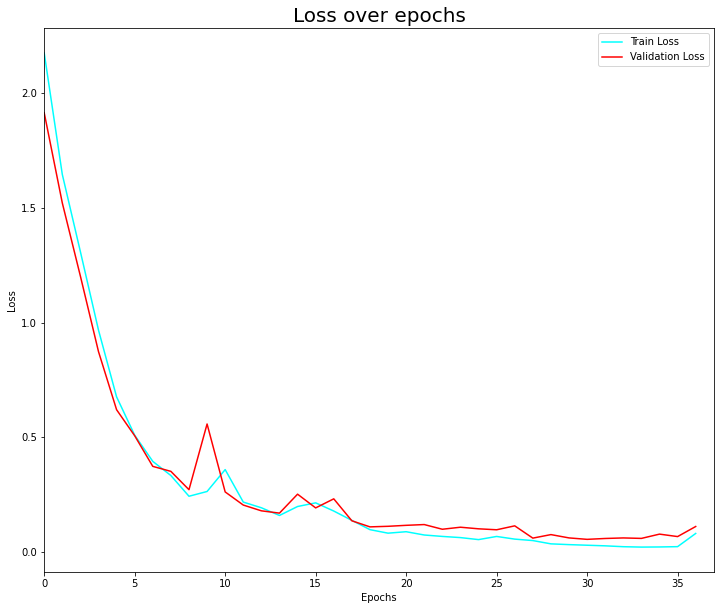

In [ ]:
epochs = np.arange(0,len(train_losses),1)
plt.figure(figsize=(12,10))
plt.plot(epochs,train_losses,color='cyan',label='Train Loss')
plt.plot(epochs,val_losses,color='red',label='Validation Loss')
plt.legend(loc='best')
plt.title("Loss over epochs",fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0,len(epochs))
plt.show()

Confusion matrix, without normalization
Confusion matrix, without normalization


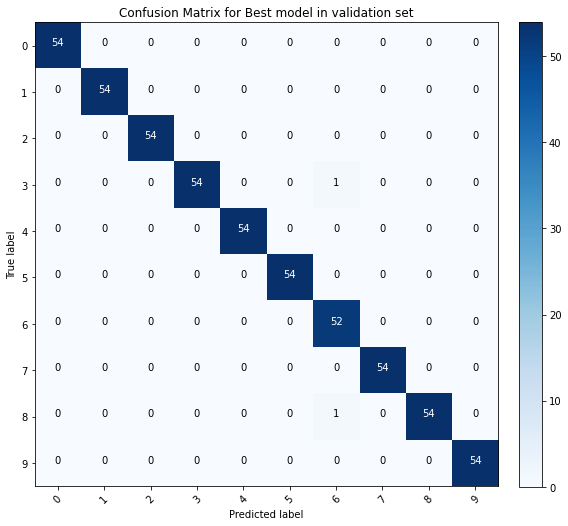

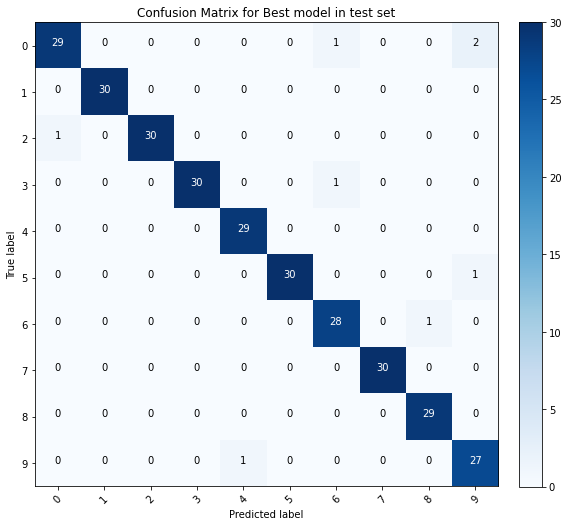

In [ ]:
cm_val = confusion_matrix(preds_val, y_val)
cm_test = confusion_matrix(preds_test, y_test)
plot_confusion_matrix(cm_val,classes=list(range(10)),title='Confusion Matrix for Best model in validation set')
plot_confusion_matrix(cm_test,classes=list(range(10)),title='Confusion Matrix for Best model in test set')

### 7)

In [ ]:
# Initialization and trainning of a BiLSTM  
bilstm = neural.BasicLSTM(X_train[0].shape[-1],rnn_size=60,output_dim=10,num_layers=1,bidirectional=True,dropout=0.3,DEVICE=torch.device('cuda'))
bilstm = fit(bilstm,100,0.0015,train_loader,valid_loader,L2_normal=0.0001, val=True,earlyStopping=True,DEVICE=torch.device('cuda'))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 : Train loss is 2.0912406359847027
Epoch 1 : Validation Loss is 1.5858159082261023
--------------------------------------------------
Epoch 2 : Train loss is 1.11941281466156
Epoch 2 : Validation Loss is 0.7841900606422837
--------------------------------------------------
Epoch 3 : Train loss is 0.6136003340623709
Epoch 3 : Validation Loss is 0.5315859977084911
--------------------------------------------------
Epoch 4 : Train loss is 0.4249177256514918
Epoch 4 : Validation Loss is 0.3455932069323075
--------------------------------------------------
Epoch 5 : Train loss is 0.28050137055902197
Epoch 5 : Validation Loss is 0.28555982853179435
--------------------------------------------------
Epoch 6 : Train loss is 0.20861319171509077
Epoch 6 : Validation Loss is 0.18898363243061345
--------------------------------------------------
Epoch 7 : Train loss is 0.15219359621293757
Epoch 7 : Validation Loss is 0.15398036563827394
--------------------------------------------------
Ep

In [ ]:
# The accuracy achieved by the above BiLSTM. 
score_test,preds_test = score(bilstm[0],test_loader)
score_val,preds_val = score(bilstm[0],valid_loader)
print('The accuracy score achieved by the above BiLSTM (in test dataset) is :','{:.2f}'.format(score_test))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


The accuracy score achieved by the above BiLSTM (in test dataset) is : 0.99


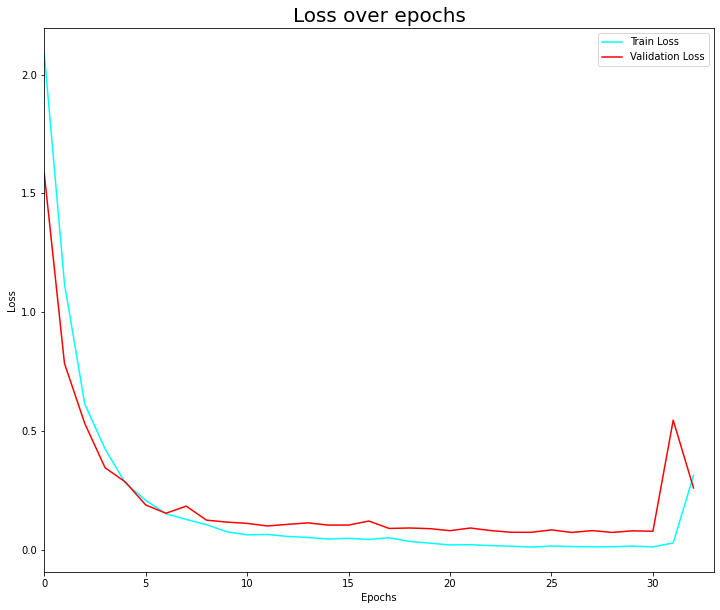

In [ ]:
train_losses = bilstm[1][0]
val_losses = bilstm[1][1]
epochs = np.arange(0,len(train_losses),1)
plt.figure(figsize=(12,10))
plt.plot(epochs,train_losses,color='cyan',label='Train Loss')
plt.plot(epochs,val_losses,color='red',label='Validation Loss')
plt.legend(loc='best')
plt.title("Loss over epochs",fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0,len(epochs))
plt.show()

Confusion matrix, without normalization
Confusion matrix, without normalization


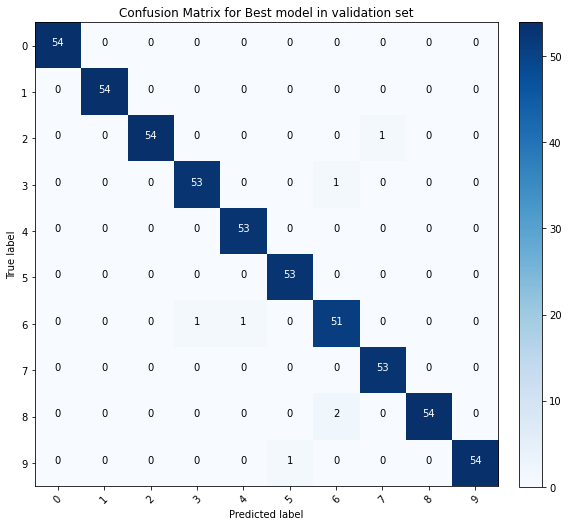

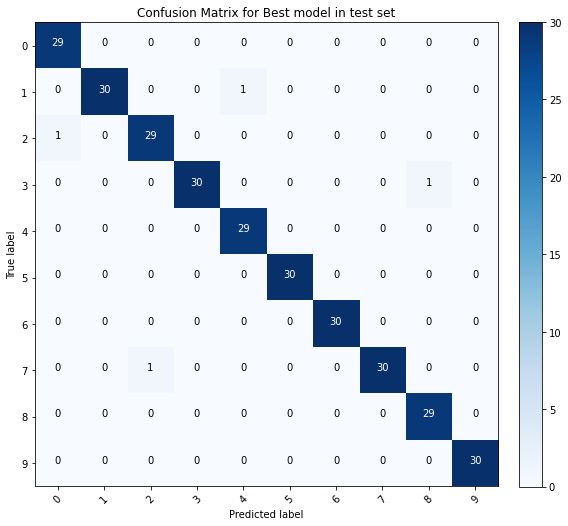

In [ ]:
cm_val = confusion_matrix(preds_val, y_val)
cm_test = confusion_matrix(preds_test, y_test)
plot_confusion_matrix(cm_val,classes=list(range(10)),title='Confusion Matrix for Best model in validation set')
plot_confusion_matrix(cm_test,classes=list(range(10)),title='Confusion Matrix for Best model in test set')

### 8-Bonus

In [ ]:
# Sort the Train and Validation Dataset in order to use pack_padded_sequence 
to_sort_train=[(len(val),i)for i,val in enumerate(X_train)]
srt_train=sorted(to_sort_train,key=lambda x:x[0],reverse=True)
X_train_srt=[X_train[i] for _,i in srt_train]
y_train_srt=[y_train[i] for _,i in srt_train]
to_sort_val=[(len(val),i)for i,val in enumerate(X_val)]
srt_val=sorted(to_sort_val,key=lambda x:x[0],reverse=True)
X_val_srt=[X_val[i] for _,i in srt_val]
y_val_srt=[y_val[i] for _,i in srt_val]
xy_train_srt=neural.FrameLevelDataset(X_train_srt,y_train_srt)
xy_val_srt=neural.FrameLevelDataset(X_val_srt,y_val_srt)
# xy_test_srt=FrameLevelDataset(X_test,y_test)
train_loader_srt = DataLoader (xy_train_srt, batch_size = 512, shuffle = False)
valid_loader_srt = DataLoader (xy_val_srt, batch_size = 32, shuffle = False)

Τα αποτελέσματα σχολίαζονται στην αναφορά καθώς υπήρξαν αρκετές διαφορετικές περιπτώσεις στα τυπώματα

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
model_padded = neural.BasicLSTM(input_dim=X_train_srt[0].shape[-1], rnn_size= 20, output_dim=10, num_layers=1,pad=True)
model_trainned_padded ,losses= fit(model_padded,3,0.05,train_loader_srt,valid_loader_srt,time_b=True)

Loss backward time is: 1.4791548252105713
Loss backward time is: 0.24724888801574707
Loss backward time is: 0.1718146800994873
Loss backward time is: 0.11801815032958984
Loss backward time is: 0.01565408706665039
Epoch 1 time is:2.215487241744995
Loss backward time is: 1.5112693309783936
Loss backward time is: 0.24367642402648926
Loss backward time is: 0.1689469814300537
Loss backward time is: 0.11572265625
Loss backward time is: 0.01582789421081543
Epoch 2 time is:2.231046676635742
Loss backward time is: 1.4814293384552002
Loss backward time is: 0.2437293529510498
Loss backward time is: 0.16901111602783203
Loss backward time is: 0.11773848533630371
Loss backward time is: 0.015214681625366211
Epoch 3 time is:2.2042763233184814


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
model_not_padded = neural.BasicLSTM(input_dim=X_train_srt[0].shape[-1], rnn_size= 20, output_dim=10, num_layers=1)
model_trainned_not_padded ,losses= fit(model_not_padded,3,0.05,train_loader_srt,valid_loader_srt,time_b=True)

Loss backward time is: 0.15046334266662598
Loss backward time is: 0.15546727180480957
Loss backward time is: 0.13860011100769043
Loss backward time is: 0.13937592506408691
Loss backward time is: 0.04520225524902344
Epoch 1 time is:1.301119089126587
Loss backward time is: 0.1557786464691162
Loss backward time is: 0.1429915428161621
Loss backward time is: 0.14108777046203613
Loss backward time is: 0.135636568069458
Loss backward time is: 0.04474472999572754
Epoch 2 time is:1.279742956161499
Loss backward time is: 0.13888859748840332
Loss backward time is: 0.14369511604309082
Loss backward time is: 0.14661884307861328
Loss backward time is: 0.14018750190734863
Loss backward time is: 0.04490518569946289
Epoch 3 time is:1.2880918979644775
